In [7]:
#import libraries
import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras import backend as K
import keras
import matplotlib.pyplot as plt
import yfinance as yf
import time

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

We first showcase the version of Keras that we are using 


In [9]:
pip show keras

Name: keras
Version: 2.15.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /Users/Morpheus/PycharmProjects/BayesianML/.venv/lib/python3.9/site-packages
Requires: 
Required-by: tensorflow-macos
Note: you may need to restart the kernel to use updated packages.


We load the data.

[*********************100%%**********************]  1 of 1 completed


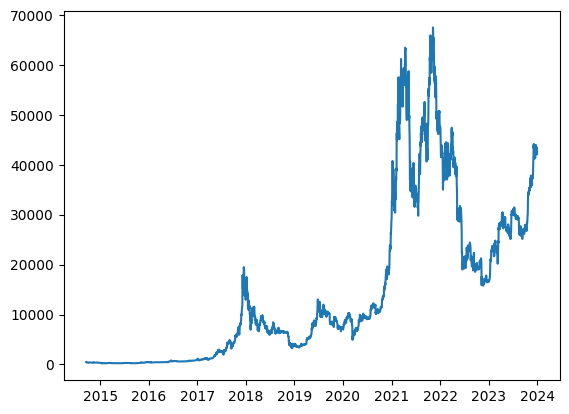

In [10]:
df = yf.download(tickers='BTC-USD', start="2012-06-01", end="2024-01-01")
plt.plot(df.index, df['Close'])

We take a look at the first five rows of our data..

In [11]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [13]:
#we are interested in predicting the closing price per day
close_price=df.filter(["Close"])

#change the data into an array
close_price_array=close_price.values

#split the data into train and test based on a percentage split
percentage=0.7
train_len=math.ceil(len(close_price_array)*percentage)

#normalising the data based on the minimum and maximum of the data
scaler=MinMaxScaler()
scaled_data=scaler.fit_transform(close_price_array)

We build a function to split the data into a training and test set. We include a so-called lookback window variable which corresponds to how many data points of $X_{train/test}$ we associate with $y_{train/test}$ i.e. each prediction of $y$ is based on $|lookback \ window|$ amount of $X$.

In [14]:
def split(data_test_train, test_train_len, lookback_window): #each y prediction is trained on |lookback_window| amount of previous days of data 
    # Create the training dataset
    train_data_split=data_test_train[0 : test_train_len, :]
    #intialise X_train and y_train
    X_train_split=[]
    y_train_split=[]
    
    for i in range(lookback_window, len(train_data_split)):
        X_train_split.append(train_data_split[i-lookback_window : i, 0])
        y_train_split.append(train_data_split[i, 0])
        
    #make X_train and y_train into arrays
    X_train_split, y_train_split=np.array(X_train_split), np.array(y_train_split)
    #reshape the data
    X_train_split=np.reshape(X_train_split, (X_train_split.shape[0], X_train_split.shape[1], 1))
    
    #create the testing dataset
    test_data_split = scaled_data[train_len - lookback_window : , :]
    # create X_test and y_test
    X_test_split = []
    y_test_split = df.iloc[test_train_len : , :]
    for i in range(lookback_window, len(test_data_split)):
        X_test_split.append(test_data_split[i - lookback_window : i, 0])
    # convert the test data to a np array and reshape the test data
    X_test_split = np.array(X_test_split)
    X_test_split = np.reshape(X_test_split, (X_test_split.shape[0], X_test_split.shape[1], 1))
    return X_train_split, y_train_split, X_test_split, y_test_split

Split the data.

In [17]:
X_train, y_train, X_test, y_test=split(scaled_data, train_len, 3)

In [18]:
# Build the LSTM Model
model = Sequential()

model.add(LSTM(units=512, return_sequences=True, activation='relu'))


model.add(LSTM(units=256, activation='relu', return_sequences=False))


model.add(Dense(units=1))

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

#compile the LSTM model
model.compile(optimizer="Adam", loss=root_mean_squared_error, metrics=['mae'])

This function finds the optimal lookback window, our hyperparameter.

In [19]:
def root_s(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true))) 

def find_best_lookback_window(data_find, len_find, values):
    best_loss = float('inf')
    best_lookback = None

    for i in values:
        X_train_loss, y_train_loss, X_test_loss, y_test_loss=split(data_find, len_find, i)
        fit_loss=model.fit(X_train_loss, y_train_loss, epochs=3, batch_size=100, verbose=1)
        predictions_loss = model.predict(X_test_loss)
        predictions_loss = scaler.inverse_transform(predictions_loss)
        loss=root_s(df["Close"][-len(predictions_loss):], predictions_loss.flatten())
        print("RMSE =",loss, "for look back window =",i)
        if loss < best_loss:
            best_loss = loss
            best_lookback = i
            predictions_loss_best = predictions_loss
            
    rmse_500=root_s(df["Close"][-len(predictions_loss_best[500:]):], predictions_loss_best[500:].flatten())
    rmse_100=root_s(df["Close"][-len(predictions_loss_best[100:]):], predictions_loss_best[100:].flatten())
    return predictions_loss_best, best_loss, rmse_500, rmse_100

In [182]:
t0=time.time()
predictions, RMSE, RMSE_500, RMSE_100=find_best_lookback_window(scaled_data, train_len, [1,2,3,5,8,10,15,20])
t1=time.time()
print(t1-t0)

Epoch 1/3
24/24 [==============================] - 3s 135ms/step - loss: 0.0075 - mae: 0.0040
Epoch 2/3
24/24 [==============================] - 3s 126ms/step - loss: 0.0073 - mae: 0.0037
Epoch 3/3
32/32 [==============================] - 1s 28ms/step
RMSE = 1348.254016998803 for look back window = 1
Epoch 1/3
24/24 [==============================] - 4s 173ms/step - loss: 0.0173 - mae: 0.0115
Epoch 2/3
24/24 [==============================] - 4s 180ms/step - loss: 0.0088 - mae: 0.0048
Epoch 3/3
32/32 [==============================] - 1s 35ms/step
RMSE = 1527.1906350785976 for look back window = 2
Epoch 1/3
24/24 [==============================] - 12s 528ms/step - loss: 0.0119 - mae: 0.0079
Epoch 2/3
24/24 [==============================] - 8s 324ms/step - loss: 0.0077 - mae: 0.0043
Epoch 3/3
32/32 [==============================] - 1s 41ms/step
RMSE = 1231.8563200936662 for look back window = 3
Epoch 1/3
24/24 [==============================] - 12s 523ms/step - loss: 0.0130 - mae: 0.0

We find our optimal lookback window as three days, and we showcase the RMSE results for our three different sets:

In [183]:
print('RMSE =', RMSE, 'full training set.')
print('RMSE =', RMSE_500, '500 days.')
print('RMSE =', RMSE_100, '100 days.')

RMSE = 1231.8563200936662 full training set.
RMSE = 652.4024193307353 500 days.
RMSE = 1093.3364056152884 100 days.


Finally we plot our results

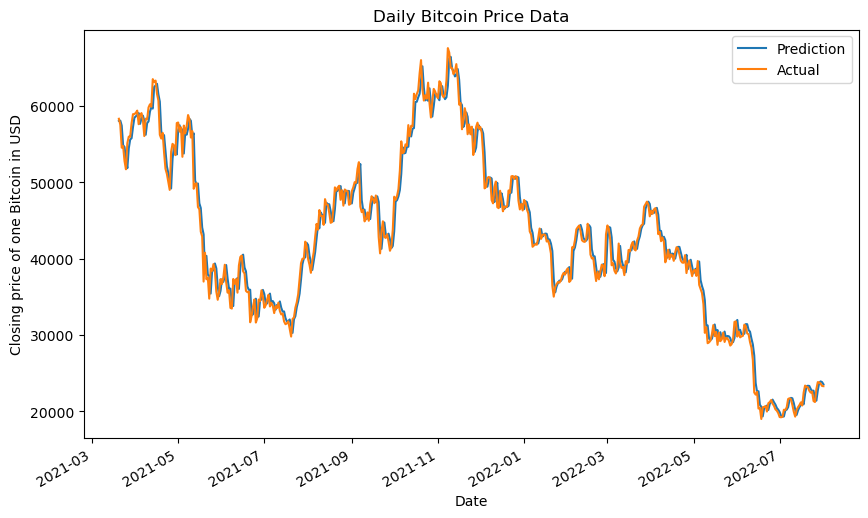

In [190]:
fig=plt.figure(figsize=(10,6))
days = df.index[-len(predictions):]
pred_days=500
plt.plot(days[:pred_days],predictions[:pred_days])
plt.plot(df["Close"][-len(predictions):][:pred_days])
plt.legend(['Prediction', 'Actual'])
fig.autofmt_xdate()
plt.title('Daily Bitcoin Price Data')
plt.ylabel('Closing price of one Bitcoin in USD')
plt.xlabel('Date')
plt.show()